<a href="https://colab.research.google.com/github/voquangtuong/AAA_drought_prediction/blob/main/nb002_M1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [227]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [228]:
import os 
os.chdir('/content/drive/MyDrive/hybrid_model_final')
outs=['save_model','tab','fig']
for out in outs:
  if not os.path.exists(out):
    os.makedirs(out)

In [229]:
import scipy
from sklearn.metrics import r2_score
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential, optimizers, backend
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow import keras # tai sao import tu tensorflow
from tensorflow.keras.models import load_model
# import statsmodels as sm
import seaborn as sns
from scipy.stats import pearsonr

#
tf.random.set_seed(10000000)
np.random.seed(10000000)

##
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised_df(data, n_in, n_out, dropnan=True): # dung cho pandas
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
################################################################################
  # functions nay dung cho array
def to_supervised_ar(data0, n_input, n_out):
  # flatten data
  data = data0.reshape((data0.shape[0]*data0.shape[1], data0.shape[1]))
  X, y = list(), list()
  in_start = 0
  # step over the entire history one time step at a time
  for _ in range(len(data)):
    # define the end of the input sequence
    in_end = in_start + n_input
    out_end = in_end + n_out
    # ensure we have enough data for this instance
    if out_end < len(data):
      x_input = data[in_start:in_end, 0]
      x_input = x_input.reshape((len(x_input), 1))
      X.append(x_input)
      y.append(data[in_end+n_output0-1:out_end, 0]) # M2 tăng lên 1 bước
  # move along one time step
    in_start += 1
  return np.array(X), np.array(y)
	#################################################################################
	# ve duong 45 do
def add_identity(axes, *line_args, **line_kwargs):
	identity, = axes.plot([], [], *line_args, **line_kwargs)
	def callback(axes):
			low_x, high_x = axes.get_xlim()
			low_y, high_y = axes.get_ylim()
			low = max(low_x, low_y)
			high = min(high_x, high_y)
			identity.set_data([low, high], [low, high])
	callback(axes)
	axes.callbacks.connect('xlim_changed', callback)
	axes.callbacks.connect('ylim_changed', callback)
	return axes
	
	# ham de tao ra cac thu muc luu tru thong so optimal cua mo hinh
	# Helper record parameter into directory
def log_dir_name(epochs):

    # The dir-name for the TensorBoard log-dir.
    s = "./19_logs/lr_{}/"
		# s = "./19_logs/lr_{0:.0e}_layers_{1}_nodes_{2}_{3}/"

    # Insert all the hyper-parameters in the dir-name.
    log_dir = s.format(epochs)

    return log_dir

###################################################################################
# =============================================================================
# Customize activate functions
# Custom activation function
from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects


def custom_activation(x):
    return (K.sigmoid(x) * 3.5) 

get_custom_objects().update({'custom_activation': Activation(custom_activation)})

# Univariate LSTM

# Thay doi du lieu

In [230]:
url_NDI3_names="https://docs.google.com/spreadsheets/d/e/2PACX-1vT3LwwkD5v6sA75MNMbOPhLlHJpKSlEFZiG-7qZkk08rOYYSYfqtaqfqVOnW1eEfumW9rSsOvk8PLVS/pub?output=csv"

dataset0=pd.read_csv(url_NDI3_names,header=0)
dataset0.head()
dataset=dataset0.iloc[:,29]
print(dataset0.columns[29])
dataset=np.array(dataset)
# print(dataset)
raw_seq=dataset[:20*12] # day la du lieu train
raw_seq_val=dataset[20*12:-96] # day la du lieu validate
raw_seq_test=dataset[-96:]
print(len(raw_seq))
print(len(raw_seq_test))

Ganghwa
240
96


In [231]:
# url_rain_runoff_soil_ganghwa="https://docs.google.com/spreadsheets/d/e/2PACX-1vRybuBH3zhwTmJ0fFz3RUuNxlJbhmySeDqNyjRpZxTEa4knE2s1rX4K79uyWHzXch4fCp2MzShsp3Jx/pub?output=csv"	 # tu nam 1980
# # rrs_df: rain runoff  soil
# rrs_df=pd.read_csv(url_rain_runoff_soil_ganghwa,header=None)
# # rrs_df.head()
# rrs_df1=rrs_df.iloc[12:,2:] # lay tu nam 1981, chi lay 3 cuoc cuoi
# rrs_df1.shape
# rrs_df1.reset_index(level=None, drop=True, inplace=True, col_level=0, col_fill='')
# rrs_df1.columns=['precipitation','runoff','soilmoisture']
# rrs_df1['NDI']=''
# rrs_df1['NDI']=dataset0
# rrs_df1.to_csv(outs[1]+'/'+'prs_NDI'+'.csv')

url_rain_runoff_soil_NDI="https://docs.google.com/spreadsheets/d/e/2PACX-1vQyBMn_8ir0BgvokMVKSncFUIWxlrhTNY_0nkA-xBEihHtP667Gtc3Wb-UlglkIPgVJODRvvqEDv0wH/pub?output=csv"	
df_prs_NDI=pd.read_csv(url_rain_runoff_soil_NDI,usecols=range(1,5))
print(df_prs_NDI.head())
df_prec_NDI=df_prs_NDI.drop(columns=['runoff','soilmoisture'])
print(df_prec_NDI)



   precipitation  runoff  soilmoisture   NDI
0           24.6    6.95        554.52 -1.63
1            8.4    9.85        559.21 -1.44
2           52.6   20.12        563.80  1.03
3           59.5   23.09        564.46 -0.44
4           83.2   28.71        565.23  0.60
     precipitation   NDI
0             24.6 -1.63
1              8.4 -1.44
2             52.6  1.03
3             59.5 -0.44
4             83.2  0.60
..             ...   ...
427           24.5  0.44
428            5.6 -0.22
429           38.5  1.01
430            1.8  1.17
431           65.0  0.15

[432 rows x 2 columns]


In [279]:
# Scaled data
dataset0=pd.read_csv(url_NDI3_names)
# dataset0.head()
arr_input0=dataset0.values[:,29]
arr_input=arr_input0.reshape(arr_input0.shape[0],1)
arr_input.shape
raw_seq=arr_input[0:20*12]
raw_seq_val=arr_input[20*12:28*12]
raw_seq_test=arr_input[28*12:36*12]

scaler01=MinMaxScaler()
raw_seq_sc=scaler01.fit_transform(raw_seq)

raw_seq_val_sc=scaler01.transform(raw_seq_val)
raw_seq_test_sc=scaler01.transform(raw_seq_test)

## Data Preparation

In [280]:
# univariate data preparation
from numpy import array
 
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
# raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps = 12
# split into samples
X, y = split_sequence(raw_seq_sc, n_steps)
X_val, y_val = split_sequence(raw_seq_val_sc, n_steps)
X_test, y_test = split_sequence(raw_seq_test_sc, n_steps)
# # summarize the data
# for i in range(len(X)):
	# print(X[i], y[i])

In [310]:
vector_date=pd.date_range(start='1981-01',end='2016-12',freq='MS')

## Vanila LSTM

INFO:tensorflow:Assets written to: save_model/vanila_LSTM.tf/assets


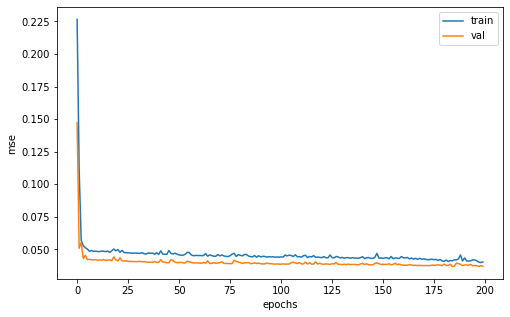

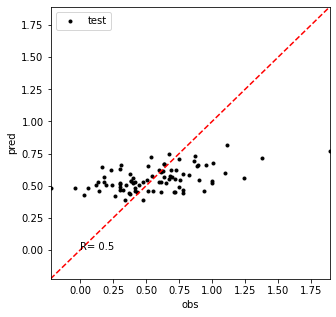

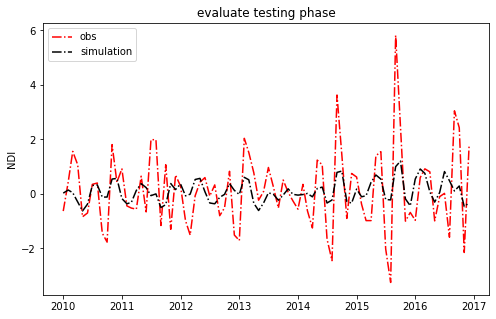

In [321]:
# univariate lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
 
 
# # split a univariate sequence into samples
# def split_sequence(sequence, n_steps):
# 	X, y = list(), list()
# 	for i in range(len(sequence)):
# 		# find the end of this pattern
# 		end_ix = i + n_steps
# 		# check if we are beyond the sequence
# 		if end_ix > len(sequence)-1:
# 			break
# 		# gather input and output parts of the pattern
# 		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
# 		X.append(seq_x)
# 		y.append(seq_y)
# 	return array(X), array(y)
 
# # define input sequence
# # raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# # choose a number of time steps
# # n_steps = 3
# # split into samples
# X, y = split_sequence(raw_seq, n_steps)
# X_val, y_val = split_sequence(raw_seq_val, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_steps = 12
# split into samples
X, y = split_sequence(raw_seq_sc, n_steps)
X_val, y_val = split_sequence(raw_seq_val_sc, n_steps)
X_test, y_test = split_sequence(raw_seq_test_sc, n_steps)
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))
# define model
model = Sequential()
model.add(LSTM(60, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=0,validation_data=(X_val,y_val))
# save lai mo hinh
model.save(outs[0]+'/'+'vanila_LSTM'+'.tf',save_format='tf')
# ve learning rate
fig,ax=plt.subplots(figsize=(8,5))
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
df_val_loss=pd.DataFrame({'val_loss':model.history.history['val_loss']})

# # print(df_val_loss)
# idxmin=df_val_loss[['val_loss']].idxmin().values
# val_loss_min_values=df_val_loss.loc[idxmin,:].values.flatten()
# print(idxmin,val_loss_min_values)
# plt.annotate('optimal epochs: '+str(idxmin[0])+'\n'+'min_val_loss: '+str(np.round(val_loss_min_values[0],3)),
#              xy=(idxmin,val_loss_min_values), xycoords='data',
#             xytext=(idxmin-50, val_loss_min_values+0.01), textcoords='data',
#             arrowprops=dict(arrowstyle="->",
#                             connectionstyle="arc3"),
#             )


plt.legend(['train','val'])
plt.xlabel('epochs')
plt.ylabel('mse')
plt.title('')
plt.savefig(outs[2]+'/'+'M1_learning_rate'+'.jpeg')

#########################################################

# demonstrate prediction
# x_input = array([70, 80, 90])
# pred=[]
# obs=[]
# for tt in np.arange(96-n_steps):
# 	# tt=1
# 	x_input0 = raw_seq_test[-(tt+n_steps+1):-(1+tt)]
# 	x_input = x_input0.reshape((1, n_steps, n_features))
# 	yhat = model.predict(x_input, verbose=0)
# 	pred.append(yhat[0][0])
# 	obs.append(raw_seq_test[-tt])
# # yhat=model.predict(X_test,verbose=0)
# pred_vanila=pred
# obs_vanila=obs
	# print('prediction:'+str(yhat)+'\n'+'obs: '+str(raw_seq[-tt]))
# ve ket qua thu 
# slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(obs_vanila, pred_vanila)
pred=model.predict(X_test)
pearson,dotincay=pearsonr(pred.flatten(),y_test.flatten())
r2_vanila=pearson
# kiem tra train
# y_train_hat=model.predict(X,verbose=0)

# r2_vanila=r2_score(pred_vanila,obs_vanila)
obs=y_test
fig,ax=plt.subplots(figsize=(5,5))
min_values1=np.min([pred,obs])
# min_values2=np.min([y.flatten(),y_train_hat.flatten()])
# min_values=np.min(min_values1,min_values2)

min_values=min_values1
max_values1=np.max([pred,obs])
# max_values2=np.max([y,y_train_hat])
# max_values=np.max(max_value1,max_values2)
max_values=max_values1
plt.xlim(min_values,max_values)
plt.ylim(min_values,max_values)
# # ve training
# plt.scatter(x=y.flatten(),
#             y=y_train_hat.flatten(),
#             s=None,
#             c='b', 
#             marker='x', 
#             cmap=None,
#             norm=None,
#             vmin=None, 
#             vmax=None,
#             alpha=None,            
#             linewidths=None,
#             edgecolors=None,plotnonfinite=False,data=None)
# ve testing
# 
plt.scatter(x=obs,
            y=pred,
            s=None,
            c='k', 
            marker='.', 
            cmap=None,
            norm=None,
            vmin=None, 
            vmax=None,
            alpha=None,            
            linewidths=None,
            edgecolors=None,plotnonfinite=False,data=None)

# ve duong 45
plt.legend(['test'])
plt.xlabel('obs')
plt.ylabel('pred')
add_identity(ax, color='r', ls='--')
plt.text(0,0,'R= '+str(round(r2_vanila,2)))
plt.savefig(outs[2]+'/'+'M1_testing'+'.jpeg')
plt.show()
plt.close()
###############################################################
# df_result_gia=dataset_test.copy
y_test_hat_rescaled=scaler01.inverse_transform(pred)
test_y_rescaled=scaler01.inverse_transform(y_test)
fig,ax=plt.subplots(figsize=(8,5))
plt.plot(vector_date[28*12+n_input0:],test_y_rescaled,'r-.')
plt.plot(vector_date[28*12+n_input0:],y_test_hat_rescaled,'k-.')
plt.legend(['obs','simulation'])

plt.ylabel('NDI')
plt.title('evaluate testing phase')
plt.show()
plt.close()



# Vanila LSTM 2 months

[[[0]
  [1]
  [2]]

 [[1]
  [2]
  [3]]

 [[2]
  [3]
  [4]]

 [[3]
  [4]
  [5]]

 [[4]
  [5]
  [6]]]
[[4]
 [5]
 [6]
 [7]
 [8]]
INFO:tensorflow:Assets written to: save_model/vanila_LSTM_2months.tf/assets


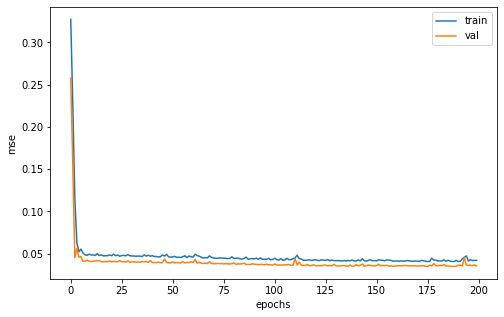

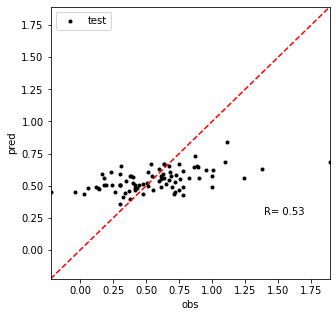

In [308]:
"""# Chọn bước thời gian cho mô hình"""
model_names=['M1','M2','M3']
####################################################################################
# for leadtime in [1,2,3]:
# for leadtime in [2]:
leadtime=2
####################################################################################
n_input0,n_output0=12,leadtime
def to_supervised(train, n_input, n_out):
  # flatten data
  data = train.reshape((train.shape[0]*train.shape[1], train.shape[1]))
  X, y = list(), list()
  in_start = 0
  # step over the entire history one time step at a time
  for _ in range(len(data)):
    # define the end of the input sequence
    in_end = in_start + n_input
    out_end = in_end + n_out
    # ensure we have enough data for this instance
    if out_end < len(data):
      x_input = data[in_start:in_end, 0]
      x_input = x_input.reshape((len(x_input), 1))
      X.append(x_input)
      y.append(data[in_end+n_output0-1:out_end, 0]) # M2 tăng lên 1 bước
  # move along one time step
    in_start += 1
  return np.array(X), np.array(y)
data_test_function=np.arange(10).reshape(10,1)
X_test_function,y_test_function=to_supervised(data_test_function,3,2)
print(X_test_function)
print(y_test_function)

################################################
# univariate lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
 
 
# # split a univariate sequence into samples
# def split_sequence(sequence, n_steps):
# 	X, y = list(), list()
# 	for i in range(len(sequence)):
# 		# find the end of this pattern
# 		end_ix = i + n_steps
# 		# check if we are beyond the sequence
# 		if end_ix > len(sequence)-1:
# 			break
# 		# gather input and output parts of the pattern
# 		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
# 		X.append(seq_x)
# 		y.append(seq_y)
# 	return array(X), array(y)
 
# # define input sequence
# # raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# # choose a number of time steps
# # n_steps = 3
# # split into samples
# X, y = split_sequence(raw_seq, n_steps)
# X_val, y_val = split_sequence(raw_seq_val, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_steps = 12
# split into samples
# thay split_sequence bang ham to_supervised
X, y = to_supervised(raw_seq_sc, n_input0,n_output0)
X_val, y_val = to_supervised(raw_seq_val_sc, n_input0,n_output0)
X_test, y_test = to_supervised(raw_seq_test_sc, n_input0,n_output0)
n_features = 1
# n_steps=leadtime # ghi lai de sot. Neu sai thi n_steps =1
n_steps=1
X = X.reshape((X.shape[0], X.shape[1], n_features))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))
# define model
model = Sequential()
model.add(LSTM(60, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=0,validation_data=(X_val,y_val))
# save lai mo hinh
model.save(outs[0]+'/'+'vanila_LSTM_2months'+'.tf',save_format='tf')
# ve learning rate
fig,ax=plt.subplots(figsize=(8,5))
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
df_val_loss=pd.DataFrame({'val_loss':model.history.history['val_loss']})

# # print(df_val_loss)
# idxmin=df_val_loss[['val_loss']].idxmin().values
# val_loss_min_values=df_val_loss.loc[idxmin,:].values.flatten()
# print(idxmin,val_loss_min_values)
# plt.annotate('optimal epochs: '+str(idxmin[0])+'\n'+'min_val_loss: '+str(np.round(val_loss_min_values[0],3)),
#              xy=(idxmin,val_loss_min_values), xycoords='data',
#             xytext=(idxmin-50, val_loss_min_values+0.01), textcoords='data',
#             arrowprops=dict(arrowstyle="->",
#                             connectionstyle="arc3"),
#             )


plt.legend(['train','val'])
plt.xlabel('epochs')
plt.ylabel('mse')
plt.title('')
plt.savefig(outs[2]+'/'+'M1_learning_rate_2months'+'.jpeg')

#########################################################

# demonstrate prediction
# x_input = array([70, 80, 90])
# pred=[]
# obs=[]
# for tt in np.arange(96-n_steps):
# 	# tt=1
# 	x_input0 = raw_seq_test[-(tt+n_steps+1):-(1+tt)]
# 	x_input = x_input0.reshape((1, n_steps, n_features))
# 	yhat = model.predict(x_input, verbose=0)
# 	pred.append(yhat[0][0])
# 	obs.append(raw_seq_test[-tt])
# # yhat=model.predict(X_test,verbose=0)
# pred_vanila=pred
# obs_vanila=obs
	# print('prediction:'+str(yhat)+'\n'+'obs: '+str(raw_seq[-tt]))
# ve ket qua thu 
# slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(obs_vanila, pred_vanila)
pred=model.predict(X_test)
obs=y_test
pearson,dotincay=pearsonr(pred.flatten(),y_test.flatten())
r2_vanila=pearson
# kiem tra train
# y_train_hat=model.predict(X,verbose=0)

# r2_vanila=r2_score(pred_vanila,obs_vanila)

fig,ax=plt.subplots(figsize=(5,5))
min_values1=np.min([pred,obs])
# min_values2=np.min([y.flatten(),y_train_hat.flatten()])
# min_values=np.min(min_values1,min_values2)

min_values=min_values1
max_values1=np.max([pred,obs])
# max_values2=np.max([y,y_train_hat])
# max_values=np.max(max_value1,max_values2)
max_values=max_values1
plt.xlim(min_values,max_values)
plt.ylim(min_values,max_values)
# # ve training
# plt.scatter(x=y.flatten(),
#             y=y_train_hat.flatten(),
#             s=None,
#             c='b', 
#             marker='x', 
#             cmap=None,
#             norm=None,
#             vmin=None, 
#             vmax=None,
#             alpha=None,            
#             linewidths=None,
#             edgecolors=None,plotnonfinite=False,data=None)
# ve testing
# 
plt.scatter(x=obs,
            y=pred,
            s=None,
            c='k', 
            marker='.', 
            cmap=None,
            norm=None,
            vmin=None, 
            vmax=None,
            alpha=None,            
            linewidths=None,
            edgecolors=None,plotnonfinite=False,data=None)

# ve duong 45
plt.legend(['test'])
plt.xlabel('obs')
plt.ylabel('pred')
add_identity(ax, color='r', ls='--')
plt.text(max_values-0.5,min_values+0.5,'R= '+str(round(r2_vanila,2)))
plt.savefig(outs[2]+'/'+'M1_testing_2months'+'.jpeg')
plt.show()
plt.close()
###############################################################

# Vanila 3 months

[[[0]
  [1]
  [2]]

 [[1]
  [2]
  [3]]

 [[2]
  [3]
  [4]]

 [[3]
  [4]
  [5]]

 [[4]
  [5]
  [6]]]
[]
INFO:tensorflow:Assets written to: save_model/vanila_LSTM_3months.tf/assets


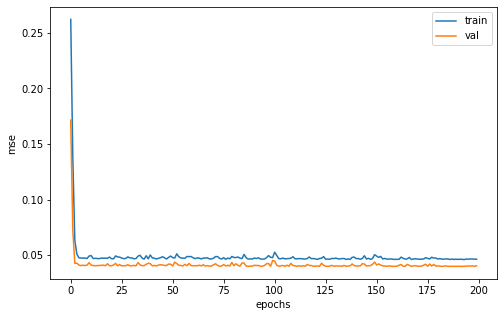

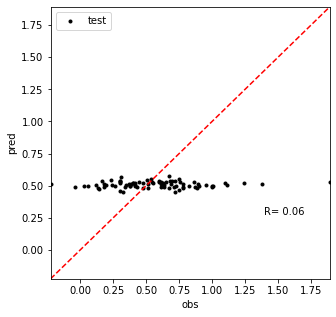

In [309]:
"""# Chọn bước thời gian cho mô hình"""
model_names=['M1','M2','M3']
####################################################################################
# for leadtime in [1,2,3]:
# for leadtime in [2]:
leadtime=3
####################################################################################
n_input0,n_output0=12,leadtime
def to_supervised(train, n_input, n_out):
  # flatten data
  data = train.reshape((train.shape[0]*train.shape[1], train.shape[1]))
  X, y = list(), list()
  in_start = 0
  # step over the entire history one time step at a time
  for _ in range(len(data)):
    # define the end of the input sequence
    in_end = in_start + n_input
    out_end = in_end + n_out
    # ensure we have enough data for this instance
    if out_end < len(data):
      x_input = data[in_start:in_end, 0]
      x_input = x_input.reshape((len(x_input), 1))
      X.append(x_input)
      y.append(data[in_end+n_output0-1:out_end, 0]) # M2 tăng lên 1 bước
  # move along one time step
    in_start += 1
  return np.array(X), np.array(y)
data_test_function=np.arange(10).reshape(10,1)
X_test_function,y_test_function=to_supervised(data_test_function,3,2)
print(X_test_function)
print(y_test_function)

################################################
# univariate lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
 
 
# # split a univariate sequence into samples
# def split_sequence(sequence, n_steps):
# 	X, y = list(), list()
# 	for i in range(len(sequence)):
# 		# find the end of this pattern
# 		end_ix = i + n_steps
# 		# check if we are beyond the sequence
# 		if end_ix > len(sequence)-1:
# 			break
# 		# gather input and output parts of the pattern
# 		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
# 		X.append(seq_x)
# 		y.append(seq_y)
# 	return array(X), array(y)
 
# # define input sequence
# # raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# # choose a number of time steps
# # n_steps = 3
# # split into samples
# X, y = split_sequence(raw_seq, n_steps)
# X_val, y_val = split_sequence(raw_seq_val, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_steps = 12
# split into samples
# thay split_sequence bang ham to_supervised
X, y = to_supervised(raw_seq_sc, n_input0,n_output0)
X_val, y_val = to_supervised(raw_seq_val_sc, n_input0,n_output0)
X_test, y_test = to_supervised(raw_seq_test_sc, n_input0,n_output0)
n_features = 1
# n_steps=leadtime # ghi lai de sot. Neu sai thi n_steps =1
n_steps=1
X = X.reshape((X.shape[0], X.shape[1], n_features))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))
# define model
model = Sequential()
model.add(LSTM(60, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=0,validation_data=(X_val,y_val))
# save lai mo hinh
model.save(outs[0]+'/'+'vanila_LSTM_3months'+'.tf',save_format='tf')
# ve learning rate
fig,ax=plt.subplots(figsize=(8,5))
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
df_val_loss=pd.DataFrame({'val_loss':model.history.history['val_loss']})

# # print(df_val_loss)
# idxmin=df_val_loss[['val_loss']].idxmin().values
# val_loss_min_values=df_val_loss.loc[idxmin,:].values.flatten()
# print(idxmin,val_loss_min_values)
# plt.annotate('optimal epochs: '+str(idxmin[0])+'\n'+'min_val_loss: '+str(np.round(val_loss_min_values[0],3)),
#              xy=(idxmin,val_loss_min_values), xycoords='data',
#             xytext=(idxmin-50, val_loss_min_values+0.01), textcoords='data',
#             arrowprops=dict(arrowstyle="->",
#                             connectionstyle="arc3"),
#             )


plt.legend(['train','val'])
plt.xlabel('epochs')
plt.ylabel('mse')
plt.title('')
plt.savefig(outs[2]+'/'+'M1_learning_rate_3months'+'.jpeg')

#########################################################

# demonstrate prediction
# x_input = array([70, 80, 90])
# pred=[]
# obs=[]
# for tt in np.arange(96-n_steps):
# 	# tt=1
# 	x_input0 = raw_seq_test[-(tt+n_steps+1):-(1+tt)]
# 	x_input = x_input0.reshape((1, n_steps, n_features))
# 	yhat = model.predict(x_input, verbose=0)
# 	pred.append(yhat[0][0])
# 	obs.append(raw_seq_test[-tt])
# # yhat=model.predict(X_test,verbose=0)
# pred_vanila=pred
# obs_vanila=obs
	# print('prediction:'+str(yhat)+'\n'+'obs: '+str(raw_seq[-tt]))
# ve ket qua thu 
# slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(obs_vanila, pred_vanila)
pred=model.predict(X_test)
obs=y_test
pearson,dotincay=pearsonr(pred.flatten(),y_test.flatten())
r2_vanila=pearson
# kiem tra train
# y_train_hat=model.predict(X,verbose=0)

# r2_vanila=r2_score(pred_vanila,obs_vanila)

fig,ax=plt.subplots(figsize=(5,5))
min_values1=np.min([pred,obs])
# min_values2=np.min([y.flatten(),y_train_hat.flatten()])
# min_values=np.min(min_values1,min_values2)

min_values=min_values1
max_values1=np.max([pred,obs])
# max_values2=np.max([y,y_train_hat])
# max_values=np.max(max_value1,max_values2)
max_values=max_values1
plt.xlim(min_values,max_values)
plt.ylim(min_values,max_values)
# # ve training
# plt.scatter(x=y.flatten(),
#             y=y_train_hat.flatten(),
#             s=None,
#             c='b', 
#             marker='x', 
#             cmap=None,
#             norm=None,
#             vmin=None, 
#             vmax=None,
#             alpha=None,            
#             linewidths=None,
#             edgecolors=None,plotnonfinite=False,data=None)
# ve testing
# 
plt.scatter(x=obs,
            y=pred,
            s=None,
            c='k', 
            marker='.', 
            cmap=None,
            norm=None,
            vmin=None, 
            vmax=None,
            alpha=None,            
            linewidths=None,
            edgecolors=None,plotnonfinite=False,data=None)

# ve duong 45
plt.legend(['test'])
plt.xlabel('obs')
plt.ylabel('pred')
add_identity(ax, color='r', ls='--')
plt.text(max_values-0.5,min_values+0.5,'R= '+str(round(r2_vanila,2)))
plt.savefig(outs[2]+'/'+'M1_testing_3months'+'.jpeg')
plt.show()
plt.close()
###############################################################

## Stacked LSTM

Text(5.82, -4.5893354415893555, '-0.02')

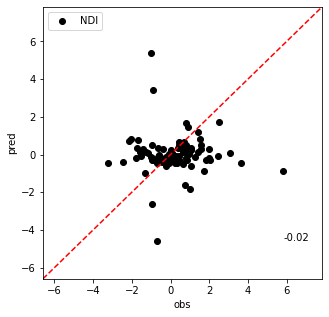

In [234]:
# univariate stacked lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
 
# split a univariate sequence
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
# raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=0)
# # demonstrate prediction
# x_input = array([70, 80, 90])
# x_input = x_input.reshape((1, n_steps, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(yhat)

# demonstrate prediction
# x_input = array([70, 80, 90])
pred=[]
obs=[]
for tt in np.arange(0,96-n_steps):
	# tt=1
	x_input0 = raw_seq_test[-(4+tt):-(1+tt)]
	x_input = x_input0.reshape((1, n_steps, n_features))
	yhat = model.predict(x_input, verbose=0)
	pred.append(yhat[0][0])
	obs.append(raw_seq_test[-tt])
pred_vanila=pred
obs_vanila=obs
	# print('prediction:'+str(yhat)+'\n'+'obs: '+str(raw_seq[-tt]))
# ve ket qua thu 
# slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(obs_vanila, pred_vanila)
# r2_vanila=slope
pearson,dotincay=pearsonr(obs_vanila,pred_vanila)
r2_vanila=pearson
# r2_vanila=r2_score(pred_vanila,obs_vanila)

fig,ax=plt.subplots(figsize=(5,5))
min_values=np.min([pred,obs])-2
max_values=np.max([pred,obs])+2
plt.xlim(min_values,max_values)
plt.ylim(min_values,max_values)
plt.scatter(x=obs,
            y=pred,
            s=None,
            c='k', 
            marker='o', 
            cmap=None,
            norm=None,
            vmin=None, 
            vmax=None,
            alpha=None,            
            linewidths=None,
            edgecolors=None,plotnonfinite=False,data=None)

# ve duong 45
plt.legend(['NDI'])
plt.xlabel('obs')
plt.ylabel('pred')
add_identity(ax, color='r', ls='--')
plt.text(max_values-2,min_values+2,str(round(r2_vanila,2)))

## Bidirectional LSTM 

Text(5.82, -4.732975959777832, '-0.13')

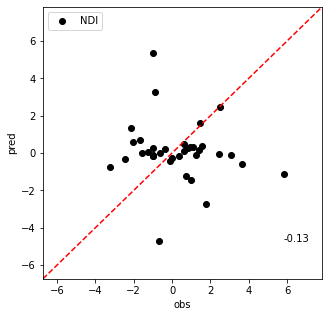

In [235]:
# univariate bidirectional lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
 
# split a univariate sequence
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
# raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=155, verbose=0)
# demonstrate prediction
# x_input = array([70, 80, 90])
# x_input = x_input.reshape((1, n_steps, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(yhat)
pred=[]
obs=[]
for tt in np.arange(0,36):
	# tt=1
	x_input0 = raw_seq_test[-(4+tt):-(1+tt)]
	x_input = x_input0.reshape((1, n_steps, n_features))
	yhat = model.predict(x_input, verbose=0)
	pred.append(yhat[0][0])
	obs.append(raw_seq_test[-tt])
pred_vanila=pred
obs_vanila=obs
	# print('prediction:'+str(yhat)+'\n'+'obs: '+str(raw_seq[-tt]))
# ve ket qua thu 
# slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(obs_vanila, pred_vanila)
# r2_vanila=slope
pearson,dotincay=pearsonr(obs_vanila,pred_vanila)
r2_vanila=pearson
# r2_vanila=r2_score(pred_vanila,obs_vanila)

fig,ax=plt.subplots(figsize=(5,5))
min_values=np.min([pred,obs])-2
max_values=np.max([pred,obs])+2
plt.xlim(min_values,max_values)
plt.ylim(min_values,max_values)
plt.scatter(x=obs,
            y=pred,
            s=None,
            c='k', 
            marker='o', 
            cmap=None,
            norm=None,
            vmin=None, 
            vmax=None,
            alpha=None,            
            linewidths=None,
            edgecolors=None,plotnonfinite=False,data=None)

# ve duong 45
plt.legend(['NDI'])
plt.xlabel('obs')
plt.ylabel('pred')
add_identity(ax, color='r', ls='--')
plt.text(max_values-2,min_values+2,str(round(r2_vanila,2)))

## CNN LSTM

Text(6.508683204650879, -3.25, '-0.07')

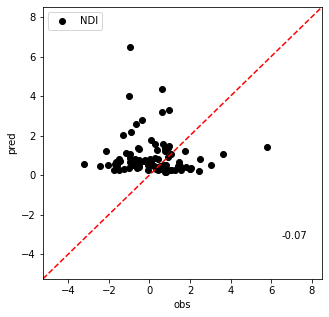

In [236]:
# univariate cnn lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
 
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps = 4
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
n_features = 1
n_seq = 2
n_steps = 2
X = X.reshape((X.shape[0], n_seq, n_steps, n_features))
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=500, verbose=0)
# # demonstrate prediction
# x_input = array([60, 70, 80, 90])
# x_input = x_input.reshape((1, n_seq, n_steps, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(yhat)
pred=[]
obs=[]
for tt in np.arange(96-n_seq-n_steps):
# tt=1
	x_input = raw_seq_test[-(n_steps+tt+n_seq+1):-(tt+1)]
	# x_input=np.array(x_input0)
	x_input = x_input.reshape((1, n_seq, n_steps, n_features))
	yhat = model.predict(x_input, verbose=0)
	pred.append(yhat[0][0])
	obs.append(raw_seq_test[-tt])
pred_vanila=pred
obs_vanila=obs
	# print('prediction:'+str(yhat)+'\n'+'obs: '+str(raw_seq[-tt]))
# ve ket qua thu 
# slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(obs_vanila, pred_vanila)
# r2_vanila=slope
pearson,dotincay=pearsonr(obs_vanila,pred_vanila)
r2_vanila=pearson
# r2_vanila=r2_score(pred_vanila,obs_vanila)

fig,ax=plt.subplots(figsize=(5,5))
min_values=np.min([pred,obs])-2
max_values=np.max([pred,obs])+2
plt.xlim(min_values,max_values)
plt.ylim(min_values,max_values)
plt.scatter(x=obs,
            y=pred,
            s=None,
            c='k', 
            marker='o', 
            cmap=None,
            norm=None,
            vmin=None, 
            vmax=None,
            alpha=None,            
            linewidths=None,
            edgecolors=None,plotnonfinite=False,data=None)

# ve duong 45
plt.legend(['NDI'])
plt.xlabel('obs')
plt.ylabel('pred')
add_identity(ax, color='r', ls='--')
plt.text(max_values-2,min_values+2,str(round(r2_vanila,2)))

## ConvLSTM

Text(5.82, -3.25, '-0.16')

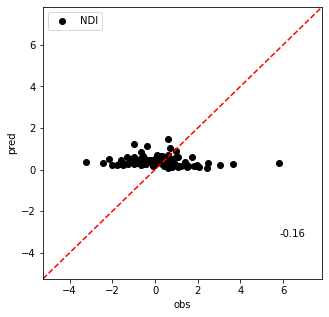

In [237]:
# univariate convlstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import ConvLSTM2D
 
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
# raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps = 4
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, rows, columns, features]
n_features = 1
n_seq = 2
n_steps = 2
X = X.reshape((X.shape[0], n_seq, 1, n_steps, n_features))
# define model
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_steps, n_features)))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=500, verbose=0)
# demonstrate prediction
# x_input = array([60, 70, 80, 90])
# x_input = x_input.reshape((1, n_seq, 1, n_steps, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(yhat)
pred=[]
obs=[]
for tt in np.arange(96-n_seq-n_steps):
# tt=1
	x_input = raw_seq_test[-(n_steps+tt+n_seq+1):-(tt+1)]
	# x_input=np.array(x_input0)
	x_input = x_input.reshape((1, n_seq, 1, n_steps, n_features))
	yhat = model.predict(x_input, verbose=0)
	pred.append(yhat[0][0])
	obs.append(raw_seq_test[-tt])
pred_vanila=pred
obs_vanila=obs
	# print('prediction:'+str(yhat)+'\n'+'obs: '+str(raw_seq[-tt]))
# ve ket qua thu 
# slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(obs_vanila, pred_vanila)
# r2_vanila=slope
pearson,dotincay=pearsonr(obs_vanila,pred_vanila)
r2_vanila=pearson
# r2_vanila=r2_score(pred_vanila,obs_vanila)

fig,ax=plt.subplots(figsize=(5,5))
min_values=np.min([pred,obs])-2
max_values=np.max([pred,obs])+2
plt.xlim(min_values,max_values)
plt.ylim(min_values,max_values)
plt.scatter(x=obs,
            y=pred,
            s=None,
            c='k', 
            marker='o', 
            cmap=None,
            norm=None,
            vmin=None, 
            vmax=None,
            alpha=None,            
            linewidths=None,
            edgecolors=None,plotnonfinite=False,data=None)

# ve duong 45
plt.legend(['NDI'])
plt.xlabel('obs')
plt.ylabel('pred')
add_identity(ax, color='r', ls='--')
plt.text(max_values-2,min_values+2,str(round(r2_vanila,2)))

# Multivariate LSTM

## Multiple Input Series

In [238]:
# scaled data
df_prec_NDI
df_prec_NDI_train, df_prec_NDI_val,df_prec_NDI_test=df_prec_NDI.iloc[:20*12,:],df_prec_NDI.iloc[20*12:28*12,:],df_prec_NDI.iloc[28*12:,:]
x_scaler=MinMaxScaler()
df_prec_NDI_train_sc=x_scaler.fit_transform(df_prec_NDI_train)
df_prec_NDI_val_sc=x_scaler.transform(df_prec_NDI_val)
df_prec_NDI_test_sc=x_scaler.transform(df_prec_NDI_test)

## Multiple input Precip +NDI

[13] [0.05449357]


Text(5.82, -3.25, '0.05')

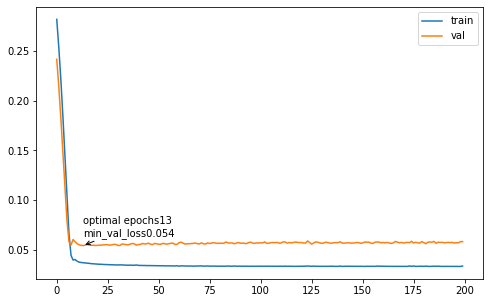

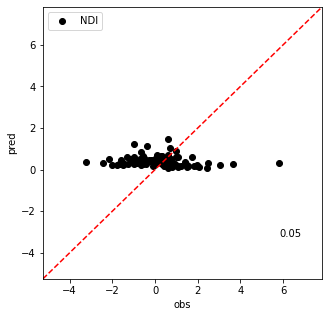

In [239]:
# multivariate lstm example
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
 
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
# in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
# in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
# out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# # convert to [rows, columns] structure
# in_seq1 = in_seq1.reshape((len(in_seq1), 1))
# in_seq2 = in_seq2.reshape((len(in_seq2), 1))
# out_seq = out_seq.reshape((len(out_seq), 1))
# # horizontally stack columns
# dataset = hstack((in_seq1, in_seq2, out_seq))
# dataset=df_prec_NDI.values[:20*12,:]

# # minmaxsacler



# dataset_val=df_prec_NDI.values[20*12:-96,:]
# dataset_test=df_prec_NDI.values[-96:,:]
dataset=df_prec_NDI_train_sc
dataset_val=df_prec_NDI_val_sc
dataset_test=df_prec_NDI_test_sc
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)
X_test, y_test = split_sequences(dataset_test, n_steps)
X_val, y_val = split_sequences(dataset_val, n_steps)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=0,validation_data=(X_val,y_val))

# ve learning rate
fig,ax=plt.subplots(figsize=(8,5))
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
df_val_loss=pd.DataFrame({'val_loss':model.history.history['val_loss']})

# print(df_val_loss)
idxmin=df_val_loss[['val_loss']].idxmin().values
val_loss_min_values=df_val_loss.loc[idxmin,:].values.flatten()
print(idxmin,val_loss_min_values)
plt.annotate('optimal epochs'+str(idxmin[0])+'\n'+'min_val_loss'+str(np.round(val_loss_min_values[0],3)),
             xy=(idxmin,val_loss_min_values), xycoords='data',
            xytext=(idxmin, val_loss_min_values+0.01), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )


plt.legend(['train','val'])
# demonstrate prediction
# x_input = array([[80, 85,95], [90, 95,105], [100, 10,105]])
# x_input = x_input.reshape((1, n_steps, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(yhat)
y_hat=model.predict(X_test, verbose=0)
pred_vanila=model.predict(X_test, verbose=0)
obs_vanila=y_test.reshape(y_test.shape[0],1)
pred_vanila=pred_vanila.flatten()
obs_vanila=obs_vanila.flatten()
# obs_vanila=np.array(obs_vanila)
# pred_vanila=np.array(pred_vanila)
# plt.plot(pred_vanila)
# plt.plot(y_test)
# slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(obs_vanila[:][:], pred_vanila[:][:])
# r2_vanila=slope
pearson,dotincay=pearsonr(obs_vanila,pred_vanila)
r2_vanila=pearson
# r2_vanila=r2_score(pred_vanila,obs_vanila)

fig,ax=plt.subplots(figsize=(5,5))
min_values=np.min([pred,obs])-2
max_values=np.max([pred,obs])+2
plt.xlim(min_values,max_values)
plt.ylim(min_values,max_values)
plt.scatter(x=obs,
            y=pred,
            s=None,
            c='k', 
            marker='o', 
            cmap=None,
            norm=None,
            vmin=None, 
            vmax=None,
            alpha=None,            
            linewidths=None,
            edgecolors=None,plotnonfinite=False,data=None)

# ve duong 45
plt.legend(['NDI'])
plt.xlabel('obs')
plt.ylabel('pred')
add_identity(ax, color='r', ls='--')
plt.text(max_values-2,min_values+2,str(round(r2_vanila,2)))

## PRS +NDI

In [240]:
# scaled data
df_prs_NDI
df_prs_NDI_train, df_prs_NDI_val,df_prs_NDI_test=df_prs_NDI.iloc[:20*12,:],df_prs_NDI.iloc[20*12:28*12,:],df_prs_NDI.iloc[28*12:,:]
x_scaler=MinMaxScaler()
df_prs_NDI_train_sc=x_scaler.fit_transform(df_prs_NDI_train)
df_prs_NDI_val_sc=x_scaler.transform(df_prs_NDI_val)
df_prs_NDI_test_sc=x_scaler.transform(df_prs_NDI_test)

Text(0.5, 1.0, 'Validate dataset scaling')

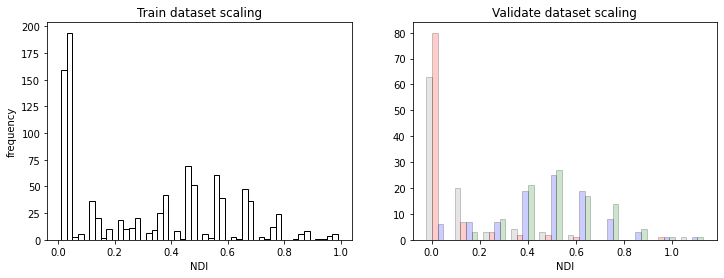

In [258]:
fig,ax=plt.subplots(figsize=(12,4),sharey=True)
plt.subplot(121)
plt.hist(df_prs_NDI_train_sc,fill=None)
plt.xlabel("NDI")
plt.ylabel("frequency")
plt.title("Train dataset scaling")

plt.subplot(122)
plt.hist(df_prs_NDI_test_sc,fill=True,color=['gray','red','blue','green'],alpha=0.2,edgecolor='k')
plt.xlabel("NDI")
# plt.ylabel("frequency")
plt.title("Validate dataset scaling")

# plt.subplot(133)
# plt.hist(data_test_01,fill=True,color='gray',alpha=0.4,edgecolor='k')
# plt.xlabel("NDI")
# # plt.ylabel("frequency")
# plt.title("Test dataset scaling")

[30] [0.05715533]


Text(5.82, -3.25, '0.06')

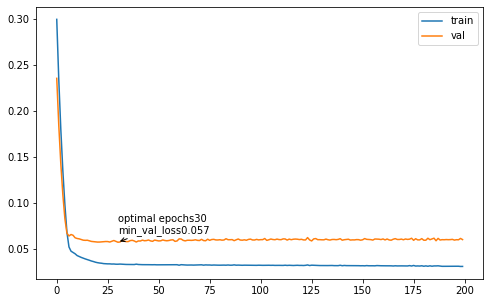

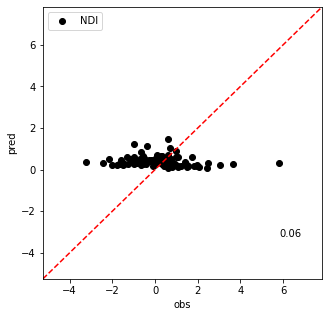

In [241]:
# multivariate lstm example
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
 
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# # define input sequence
# in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
# in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
# out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# # convert to [rows, columns] structure
# in_seq1 = in_seq1.reshape((len(in_seq1), 1))
# in_seq2 = in_seq2.reshape((len(in_seq2), 1))
# out_seq = out_seq.reshape((len(out_seq), 1))
# # horizontally stack columns
# # dataset = hstack((in_seq1, in_seq2, out_seq))
# dataset=df_prs_NDI.values[:-96,:]
# dataset_val=df_prs_NDI.values[20*12:-96,:]
# dataset_test=df_prs_NDI.values[-96:,:]
dataset=df_prs_NDI_train_sc
dataset_val=df_prs_NDI_val_sc
dataset_test=df_prs_NDI_test_sc
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)
X_test, y_test = split_sequences(dataset_test, n_steps)
X_val, y_val = split_sequences(dataset_val, n_steps)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=0,validation_data=(X_val,y_val))
# ve learning rate
fig,ax=plt.subplots(figsize=(8,5))
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
df_val_loss=pd.DataFrame({'val_loss':model.history.history['val_loss']})

# print(df_val_loss)
idxmin=df_val_loss[['val_loss']].idxmin().values
val_loss_min_values=df_val_loss.loc[idxmin,:].values.flatten()
print(idxmin,val_loss_min_values)
plt.annotate('optimal epochs'+str(idxmin[0])+'\n'+'min_val_loss'+str(np.round(val_loss_min_values[0],3)),
             xy=(idxmin,val_loss_min_values), xycoords='data',
            xytext=(idxmin, val_loss_min_values+0.01), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )


plt.legend(['train','val'])
# demonstrate prediction
# x_input = array([[80, 85,95], [90, 95,105], [100, 10,105]])
# x_input = x_input.reshape((1, n_steps, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(yhat)
y_hat=model.predict(X_test, verbose=0)
pred_vanila=model.predict(X_test, verbose=0)
obs_vanila=y_test.reshape(y_test.shape[0],1)
pred_vanila=pred_vanila.flatten()
obs_vanila=obs_vanila.flatten()
# obs_vanila=np.array(obs_vanila)
# pred_vanila=np.array(pred_vanila)
# plt.plot(pred_vanila)
# plt.plot(y_test)
# slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(obs_vanila[:][:], pred_vanila[:][:])
# r2_vanila=slope
pearson,dotincay=pearsonr(obs_vanila,pred_vanila)
r2_vanila=pearson
# r2_vanila=r2_score(pred_vanila,obs_vanila)

fig,ax=plt.subplots(figsize=(5,5))
min_values=np.min([pred,obs])-2
max_values=np.max([pred,obs])+2
plt.xlim(min_values,max_values)
plt.ylim(min_values,max_values)
plt.scatter(x=obs,
            y=pred,
            s=None,
            c='k', 
            marker='o', 
            cmap=None,
            norm=None,
            vmin=None, 
            vmax=None,
            alpha=None,            
            linewidths=None,
            edgecolors=None,plotnonfinite=False,data=None)

# ve duong 45
plt.legend(['NDI'])
plt.xlabel('obs')
plt.ylabel('pred')
add_identity(ax, color='r', ls='--')
plt.text(max_values-2,min_values+2,str(round(r2_vanila,2)))

## Multiple Parallel Series

In [242]:
# multivariate output stacked lstm example
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
 
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=400, verbose=0)
# demonstrate prediction
x_input = array([[70,75,145], [80,85,165], [90,95,185]])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[ 99.94069 105.59625 205.57649]]


# Multi-Step LSTM 

## Data Preparation

In [243]:
# multi-step data preparation
from numpy import array
 
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps_in, n_steps_out = 3, 2
# split into samples
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
# summarize the data
for i in range(len(X)):
	print(X[i], y[i])

[10 20 30] [40 50]
[20 30 40] [50 60]
[30 40 50] [60 70]
[40 50 60] [70 80]
[50 60 70] [80 90]


## Vector Output

In [244]:
# univariate multi-step vector-output stacked lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
 
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps_in, n_steps_out = 3, 2
# split into samples
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=50, verbose=0)
# demonstrate prediction
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[122.224815 130.56343 ]]


## Encoder-Decoder 

Text(5.82, -3.25, '-0.08')

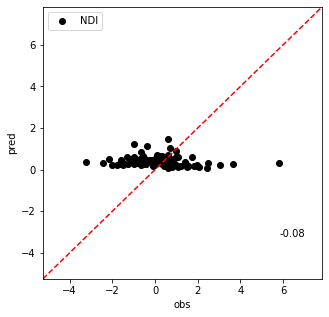

In [245]:
# univariate multi-step encoder-decoder lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
 
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
# raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps_in, n_steps_out = 3, 1
# split into samples
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
X_test, y_test = split_sequence(raw_seq_test, n_steps_in, n_steps_out)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
y = y.reshape((y.shape[0], y.shape[1], n_features))

X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=100, verbose=0)
# # demonstrate prediction
# x_input = array([70, 80, 90])
# x_input = x_input.reshape((1, n_steps_in, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(yhat)
y_hat=model.predict(X_test, verbose=0)
pred_vanila=model.predict(X_test, verbose=0)
obs_vanila=y_test.reshape(y_test.shape[0],1)
pred_vanila=pred_vanila.flatten()
obs_vanila=obs_vanila.flatten()
# obs_vanila=np.array(obs_vanila)
# pred_vanila=np.array(pred_vanila)
# plt.plot(pred_vanila)
# plt.plot(y_test)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(obs_vanila[:][:], pred_vanila[:][:])
r2_vanila=slope
# r2_vanila=r2_score(pred_vanila,obs_vanila)

fig,ax=plt.subplots(figsize=(5,5))
min_values=np.min([pred,obs])-2
max_values=np.max([pred,obs])+2
plt.xlim(min_values,max_values)
plt.ylim(min_values,max_values)
plt.scatter(x=obs,
            y=pred,
            s=None,
            c='k', 
            marker='o', 
            cmap=None,
            norm=None,
            vmin=None, 
            vmax=None,
            alpha=None,            
            linewidths=None,
            edgecolors=None,plotnonfinite=False,data=None)

# ve duong 45
plt.legend(['NDI'])
plt.xlabel('obs')
plt.ylabel('pred')
add_identity(ax, color='r', ls='--')
plt.text(max_values-2,min_values+2,str(round(r2_vanila,2)))

# Multivariate Multi-steps 

## Multiple input Multiple-step Ouput

In [246]:
# multivariate multi-step data preparation
from numpy import array
from numpy import hstack
 
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out-1
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps_in, n_steps_out = 3, 2
# covert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
print(X.shape, y.shape)
# summarize the data
for i in range(len(X)):
	print(X[i], y[i])

(6, 3, 2) (6, 2)
[[10 15]
 [20 25]
 [30 35]] [65 85]
[[20 25]
 [30 35]
 [40 45]] [ 85 105]
[[30 35]
 [40 45]
 [50 55]] [105 125]
[[40 45]
 [50 55]
 [60 65]] [125 145]
[[50 55]
 [60 65]
 [70 75]] [145 165]
[[60 65]
 [70 75]
 [80 85]] [165 185]


In [247]:
# multivariate multi-step stacked lstm example
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
 
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out-1
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
# dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps_in, n_steps_out = 3, 2
# covert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=0)
# demonstrate prediction
x_input = array([[70, 75], [80, 85], [90, 95]])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[185.45245 206.68456]]


## Multiple Parallel Input and Multi-Step Output

In [248]:
# multivariate multi-step data preparation
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
 
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps_in, n_steps_out = 3, 2
# covert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
print(X.shape, y.shape)
# summarize the data
for i in range(len(X)):
	print(X[i], y[i])

(5, 3, 3) (5, 2, 3)
[[10 15 25]
 [20 25 45]
 [30 35 65]] [[ 40  45  85]
 [ 50  55 105]]
[[20 25 45]
 [30 35 65]
 [40 45 85]] [[ 50  55 105]
 [ 60  65 125]]
[[ 30  35  65]
 [ 40  45  85]
 [ 50  55 105]] [[ 60  65 125]
 [ 70  75 145]]
[[ 40  45  85]
 [ 50  55 105]
 [ 60  65 125]] [[ 70  75 145]
 [ 80  85 165]]
[[ 50  55 105]
 [ 60  65 125]
 [ 70  75 145]] [[ 80  85 165]
 [ 90  95 185]]


In [249]:
# multivariate multi-step encoder-decoder lstm example
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
 
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps_in, n_steps_out = 3, 2
# covert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=300, verbose=0)
# demonstrate prediction
x_input = array([[60, 65, 125], [70, 75, 145], [80, 85, 165]])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[[ 90.64668   95.95445  186.02055 ]
  [100.636215 105.7032   206.52702 ]]]


# HOC THEM

In [250]:
df=df_prec_NDI
x_scaler = MinMaxScaler()
scaled_xdata = x_scaler.fit_transform(df)
scaled_xdata_inv = x_scaler.inverse_transform(scaled_xdata)

In [251]:
# kiem tra
dfx=pd.DataFrame({'A':np.arange(1,10),'B':np.arange(10,100,10)})
dfx_train=dfx.iloc[:6,:]
dfx_test=dfx.iloc[6:,:]
print(dfx)
print(dfx_train)
print(dfx_test)

   A   B
0  1  10
1  2  20
2  3  30
3  4  40
4  5  50
5  6  60
6  7  70
7  8  80
8  9  90
   A   B
0  1  10
1  2  20
2  3  30
3  4  40
4  5  50
5  6  60
   A   B
6  7  70
7  8  80
8  9  90


In [252]:
x_scaler = MinMaxScaler()
scaled_xdata_train = x_scaler.fit_transform(dfx_train)
scaled_xdata_train

array([[0. , 0. ],
       [0.2, 0.2],
       [0.4, 0.4],
       [0.6, 0.6],
       [0.8, 0.8],
       [1. , 1. ]])

In [253]:
scaled_xdata_inv = x_scaler.inverse_transform(scaled_xdata_train)
scaled_xdata_inv

array([[ 1., 10.],
       [ 2., 20.],
       [ 3., 30.],
       [ 4., 40.],
       [ 5., 50.],
       [ 6., 60.]])

In [254]:
scaled_xdata_test=x_scaler.transform(dfx_test)
scaled_xdata_test

array([[1.2, 1.2],
       [1.4, 1.4],
       [1.6, 1.6]])

In [255]:
scaled_xdata_inv_test = x_scaler.inverse_transform(scaled_xdata_test)
scaled_xdata_inv_test

array([[ 7., 70.],
       [ 8., 80.],
       [ 9., 90.]])